# Parte 2: Light-Up (Akari)
---

## Dependências

Antes de executar este caderno, pode ser necessário instalar previamente as dependências em seu sistema. Isso pode ser feito com os seguintes comandos:
```bash
pip install --user numpy
```

In [5]:
import numpy as np
import random
import time
from copy import copy, deepcopy
from PIL import Image, ImageDraw, ImageFont

## Importando os dados

In [22]:
game_files = ["games/game1.txt", "games/game2.txt", "games/game3.txt", "games/game4.txt", ]
games = []

for game_file in game_files:
    game = np.loadtxt(game_file, dtype='str', delimiter=' ')
    games.append(game)

# Mostrar um game só de exemplo
games[0]

array([['-', '-', '1', '-', '-', '-', '-'],
       ['-', '-', '-', '0', 'X', '-', '-'],
       ['-', '0', '-', '-', '-', '-', '2'],
       ['-', '0', '-', 'X', '-', 'X', '-'],
       ['X', '-', '-', '-', '-', '1', '-'],
       ['-', '-', '3', '1', '-', '-', '-'],
       ['-', '-', '-', '-', 'X', '-', '-']], dtype='<U1')

## Funções para desenhar o tabuleiro na tela

In [104]:
# Tamanho dos quadrados do tabuleiro (editável)
w, h = 30, 30

# Espaçamento entre os tabuleiros (editável)
hspace, vspace = 40, 40

# Dimensão do tabuleiro
x, y = len(game[0]), len(game)

# Desenha o outlier do tabuleiro
img = Image.new('RGB', (x * w + 2 + hspace, y * h + 2 + vspace), color = "white")
d = ImageDraw.Draw(img)

# Funções para desenhar os shapes
def draw_lamp(pos):
    shape = [(pos[0], pos[1]), (pos[0] + w, pos[1] + h)]
    d.rectangle(shape, fill ="#ffff33", outline ="black")
    d.ellipse(shape, fill = 'white', outline ='black')
    
def draw_wall(pos):
    shape = [(pos[0], pos[1]), (pos[0] + w, pos[1] + h)]
    d.rectangle(shape, fill ="black", outline ="black")
    
def draw_numbered_wall(pos, num):
    draw_wall(pos)
    pos = (pos[0] + w/2 - 1, pos[1] + h/2 - 1)
    d.text(pos, str(num), fill="white")
    
def draw_illuminated(pos):
    shape = [(pos[0], pos[1]), (pos[0] + w, pos[1] + h)]
    d.rectangle(shape, fill ="yellow", outline ="black")
    
def draw_non_illuminated(pos):
    shape = [(pos[0], pos[1]), (pos[0] + w, pos[1] + h)]
    d.rectangle(shape, fill ="grey", outline ="black")
    
# Funções para mover o cursor de desenho
def step(pos, idx_pos):
    pos = (pos[0] + w, pos[1])
    idx_pos = (idx_pos[0] + 1, idx_pos[1])
    return pos, idx_pos
    
def new_line(pos, idx_pos):
    pos = (0, pos[1] + h)
    idx_pos = (0, idx_pos[1] + 1)
    return pos, idx_pos

# Função para desenhar o tabuleiro completo
def draw_state(state):
    # Preprocessar iluminação
    dark_spots = state.getDarkSpots()
    
    state = state.state
    # Desenhar
    pos = (0, 0)
    idx_pos = (0, 0)
    for line in state:
        for element in line:
            if element == '-':
                if (idx_pos[1], idx_pos[0]) in dark_spots:
                    draw_non_illuminated(pos)
                else:
                    draw_illuminated(pos)
            elif element == 'L':
                draw_lamp(pos)
            elif element == 'X':
                draw_wall(pos)
            else:
                draw_numbered_wall(pos, int(element))
            pos, idx_pos = step(pos, idx_pos)
        pos, idx_pos = new_line(pos, idx_pos)
    return img

## Pré-Game

In [105]:
class Number():
    def __init__(self, pos, number):
        self.pos = pos
        self.n = number

class State():
    def __init__(self, game):
        self.state = copy(game)
        self.score = 0
        self.lamps = list()
        self.criticalLamps = list()
        self.numbers = list()
        self.enemyLamps = 0
        self.darkSpots = 0
        self.size = len(game)

    def set_initial_lamps(self):
        ## Set lamps initial positions
        for j in range (self.size):
            freePositions = 0
            for i in range (self.size): 
                if self.state[i][j] == '-': 
                    freePositions += 1
                else:
                    if freePositions > 0:
                        ## Set lamp on random position
                        l = random.randrange(i - freePositions, i)
                        self.lamps.append((l, j))
                        freePositions = 0
                    
                    ## If it is a number
                    if self.state[i][j] != '-' and self.state[i][j] != 'X':
                        self.numbers.append( Number( (i, j), int( self.state[i][j] ) ) )

            if freePositions > 0:
                l = random.randrange(self.size - freePositions, self.size)
                self.lamps.append((l, j))
        
        ## Change State
        for l in self.lamps:
            self.state[l[0]][l[1]] = 'L'

        ## Critical Lamps
        direction = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        for numb in self.numbers:
            if numb.n is 0:
                i, j = numb.pos
                for di in direction:
                    ii = i + di[0]
                    jj = j + di[1]
                    if ii > -1 and ii < self.size and jj > -1 and jj < self.size and self.state[ii][jj] == 'L':
                        self.criticalLamps.append((ii, jj))

        self.evaluateScore()
    
    def evaluateScore(self):
        # Lamps that see each other 
        enemyLamps = 0
        for i in range (self.size):
            lamps = 0
            for j in range (self.size):
                ## lamp found
                if self.state[i][j] == 'L': 
                    if lamps != 0:
                        enemyLamps += 1
                    lamps = 1
                ## wall found
                elif self.state[i][j] != 'L' and self.state[i][j] != '-':
                     lamps = 0
        
        # Not illuminated spots
        darkSpots = set()
        for i in range(self.size):
            for j in range(self.size):
                if self.state[i][j] == '-':
                    darkSpots.add((i, j))

        for lamp in self.lamps:
            # Search in column
            for i in range(lamp[0] + 1, self.size):
                if self.state[i][lamp[1]] == '-':
                    if (i, lamp[1]) in darkSpots:
                        darkSpots.remove((i, lamp[1]))
                else:
                    break

            for i in range(lamp[0] - 1, -1, -1):
                if self.state[i][lamp[1]] == '-':
                    if (i, lamp[1]) in darkSpots:
                        darkSpots.remove((i, lamp[1]))
                else:
                    break
            
            # Search in line
            for j in range(lamp[1] + 1, self.size):
                if self.state[lamp[0]][j] == '-':
                    if (lamp[0], j) in darkSpots:
                        darkSpots.remove((lamp[0], j))
                else:
                    break

            for j in range(lamp[1] - 1, -1, -1):
                if self.state[lamp[0]][j] == '-':
                    if (lamp[0], j) in darkSpots:
                        darkSpots.remove((lamp[0], j))
                else:
                    break
        
        # Critical Lamps, neighbours of number cells.
        restrictions = 0
        direction = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        for numb in self.numbers:
            i, j = numb.pos
            neighbours = 0
            for di in direction:
                ii = i + di[0]
                jj = j + di[1]
                if ii > -1 and ii < self.size and jj > -1 and jj < self.size and self.state[ii][jj] == 'L':
                    neighbours += 1
                    if numb.n == 0 and (ii, jj) not in self.criticalLamps:
                        self.criticalLamps.append((ii, jj))
            restrictions += abs(neighbours - numb.n)
        
        self.score = restrictions*10 + len(darkSpots)*1 + enemyLamps*5
        
    def getDarkSpots(self):
        # Not illuminated spots
        darkSpots = set()
        for i in range(self.size):
            for j in range(self.size):
                if self.state[i][j] == '-':
                    darkSpots.add((i, j))

        for lamp in self.lamps:
            # Search in column
            for i in range(lamp[0] + 1, self.size):
                if self.state[i][lamp[1]] == '-':
                    if (i, lamp[1]) in darkSpots:
                        darkSpots.remove((i, lamp[1]))
                else:
                    break

            for i in range(lamp[0] - 1, -1, -1):
                if self.state[i][lamp[1]] == '-':
                    if (i, lamp[1]) in darkSpots:
                        darkSpots.remove((i, lamp[1]))
                else:
                    break
            
            # Search in line
            for j in range(lamp[1] + 1, self.size):
                if self.state[lamp[0]][j] == '-':
                    if (lamp[0], j) in darkSpots:
                        darkSpots.remove((lamp[0], j))
                else:
                    break

            for j in range(lamp[1] - 1, -1, -1):
                if self.state[lamp[0]][j] == '-':
                    if (lamp[0], j) in darkSpots:
                        darkSpots.remove((lamp[0], j))
                else:
                    break
        return darkSpots

<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-105-b4e0866e12c2>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if numb.n is 0:


In [106]:
def generateNextState(current): 
    nextState = deepcopy(current)

    # Select a lamp
    if len(nextState.criticalLamps) != 0:
        l = random.choice(nextState.criticalLamps)
    else:
        l = random.choice(nextState.lamps)
    ## More likely to move a Lamp
    action = random.randrange(0, 5) 

    ## Remove Lamp
    if action == 0:
        nextState.lamps.remove(l)
        if l in nextState.criticalLamps:
            nextState.criticalLamps.remove(l)
        nextState.state[l[0]][l[1]] = '-'
        nextState.evaluateScore()
    ## Move Lamp
    else:
        validPositions = list()
        for i in range(l[0] + 1, nextState.size):
            if nextState.state[i][l[1]] == '-':
                validPositions.append((i, l[1]))
            else:
                break

        for i in range(l[0] - 1, -1, -1):
            if nextState.state[i][l[1]] == '-':
                validPositions.append((i, l[1]))
            else:
                break

        if(len(validPositions) != 0):
            newLamp = random.choice(validPositions)
            nextState.lamps.remove(l)
            if l in nextState.criticalLamps:
                nextState.criticalLamps.remove(l)
            nextState.state[l[0]][l[1]] = '-'
            nextState.lamps.append(newLamp)
            nextState.state[newLamp[0]][newLamp[1]] = 'L'
            nextState.evaluateScore()

    return nextState

### HillClimbing

In [107]:
initial_states = []
final_states = []
for game in games:
    initial_states.append(State(game))
    count = 1
    while True:
        current = State(game)
        current.set_initial_lamps()
        plato = 150
        #print("Inicio: score:", current.score)
        #print(current.state)


        while True:
            nextState = generateNextState(current)
            # DEBUG: Salvar imagens das etapas intermediárias
            # draw_state(nextState).save('images/debug-step-' + str(count) + '.png')
            count = count + 1
            if nextState.score == 0:
                break

            if nextState.score < current.score:
                current = nextState
                #print("Melhorou, score:", current.score)
                # print(current.state)
                plato = 150
            else:
                plato -= 1
                if plato == 0:
                    break

        #print("Melhorou, score:", current.score)
        if nextState.score == 0:
            #print(nextState.state)
            break
    final_states.append(nextState)

## Visualização do Jogo

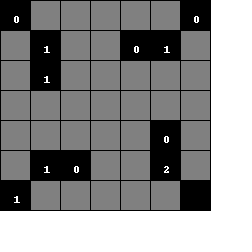

In [108]:
# Estado inicial do jogo

draw_state(initial_states[1])

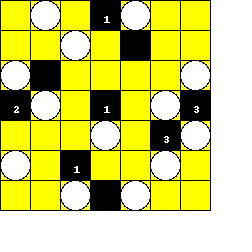

In [109]:
# Estado final do processamento
draw_state(nextState)

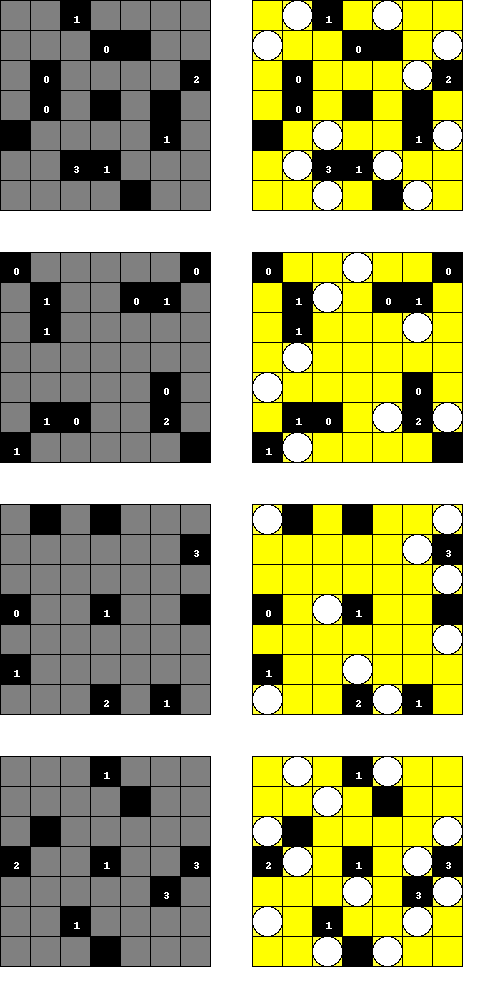

In [113]:
# Monta as imagens

# Before and After
before_after_images = []
for i in range(len(initial_states)):
    images = []
    images.append(np.asarray(draw_state(initial_states[i])))
    images.append(np.asarray(draw_state(final_states[i])))
    side_by_side_image = Image.fromarray(np.hstack(images))
    before_after_images.append(side_by_side_image)

    
# Horizontal Stack
images = []
for image in before_after_images:
    images.append(np.asarray(image))

Image.fromarray(np.vstack(images))